# Problem Set 4 (17.05.2022)
## Exercise 1
<br> Consider the following data generating process in which we have *n* observations and one covariate *X* that enters the DGP nonlinearly, additional to a constant.
<br>
<br> $X\sim \mathcal{N}_{p}(\boldsymbol{0},\sigma^{2})$.
<br> $\boldsymbol{\beta} = (1\;\;1.5\;\;-1.5\;\;1.5\;\;0.5)$
<br>
<br>and the errors are drawn from a normal distribution, that is $\varepsilon\sim\mathcal{N}(0,1)$.
<br>
<br> Suppose we have computed the fit at a particluar value $x_{0}$:
<br> $\hat f(x_{0})=\hat\beta_{0}+\hat\beta_{1}x_{0}+\hat\beta_{2}x_{0}^{2}+\hat\beta_{3}x_{0}^{3}+\hat\beta_{4}x_{0}^{4}$.
<br> The variance ${Var}[\hat f(x_{0}]$ can be calculated as follows:
<br> Use $\hat\beta_{j}$ (fit with least squares).
<br> $\hat{C}$ is the 5 x 5 covariance matrix and $\ell_{0}^{T}=(1,x_{0}^{},x_{0}^{2},x_{0}^{3},x_{0}^{4})$.
<br> Then, ${Var}[\hat f(x_{0})]=\ell_{0}^{T}\hat{C}\ell_{0}$.
<br> To retrive the point-wise standard errors, we take the square root of the point-wise variances.
<br> Twice the standard error is a good approximation of a normal confidence interval with $\alpha$= 5% (or you may use the normal quantile).
<br> This computation is repeated at each reference point along the range of x.

In [51]:
# install.packages("ggplot2")
# install.packages("emg")
library(ggplot2)
library(emg)

In [52]:
set.seed(1234)
n = 200 #no. of observations
beta0 = 1
beta1 = 1.5
beta2 = -1.5
beta3 = 1.5
beta4 = 0.5
beta = rbind(beta0, beta1, beta2, beta3, beta4) #vector of true betas
mean.x <- 0 #mean of the covariate
sd.x <- 0.5 #stand. dev. of the covariate
mean.eps <- 0 #mean of the error term
sd.eps <- 1 #variance of the error term


#DGP-Function
dgp = function(n, beta, mean.x, sd.x, mean.eps, sd.eps){
  x <- rnorm(n, mean.x, sd.x)
  X <- cbind(rep(1,n), x^1, x^2, x^3, x^4)
  eps <- rnorm(n, mean.eps, sd.eps)
  y <- X %*% beta + eps
  return(cbind(y,X))
}

#function to calculate analytical point-wise standard errors for multiple values x0 at once
se.analytical_vector = function(x0, y, X, linModel){
  #linModel = lm(y~X+0)
  C_hat = vcov(linModel)
  l = rbind(rep(1, length(x0)), x0, x0^2, x0^3, x0^4)
  return(sqrt(diag(t(l) %*% C_hat %*% l)))
}

#function to generate B bootstrap samples. Returns a list. The elements of the list are the different bootstrap samples
samples.bs = function(B, data){
  Z = list()
  N = nrow(data)
  for (i in 1:B){
    indices = sample(seq(1:N), replace = TRUE)
    Z[[i]] = data[indices,]
  }
  return(Z)
}

#function to fit linear model to each bootstrap model. 
#If X_i is the i-th bootstrap sample, then the function returns a matrix, where each column is the prediction y_hat_i = X * beta_hat_i. 
fit.bs = function(samples, x0){
  Z = samples
  B = length(samples)
  X0 = cbind(1, x0, x0^2, x0^3, x0^4)
  result_bs = list()
  Y_hat = matrix(0, nrow = length(x0), ncol = B)
  for (i in 1:B){
    result_bs[[i]] = lm(Z[[i]][,1]~Z[[i]][,2:6]+0)
    Y_hat[,i] = X0 %*% result_bs[[i]]$coefficients
  }
  return(Y_hat)
}

a) Calculate the analytical standard errors for the polynomial specification above (as presented in the lecture) and use these <br> to calculate the approximate confidence intervals as $2*SE$ for each value of *X* you consider.

In [53]:
data = dgp(n, beta, mean.x, sd.x, mean.eps, sd.eps) #Generate data
y = data[,1]
X = data[,2:6]
linModel = lm(y~X+0)
beta_hat = linModel$coefficients

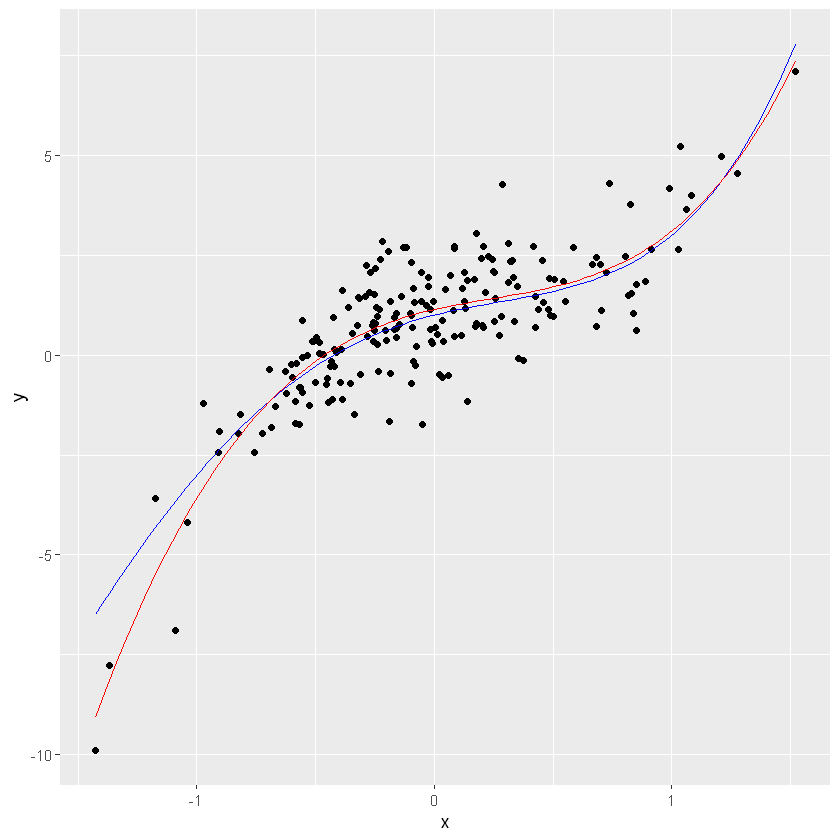

In [54]:
#Visualize the data
df <- data.frame(X[,2], y)
fun.true <- function(x) beta0 + beta1*x + beta2*x^2 + beta3*x^3 + beta4*x^4
fun.est <- function(x) beta_hat[1] + beta_hat[2]*x + beta_hat[3]*x^2 + beta_hat[4]*x^3 + beta_hat[5]*x^4
ggp <- ggplot(df, aes(X[,2], y)) + geom_point() + 
  xlim(min(X[,2]), max(X[,2])) + 
  labs(x = "x") +
  stat_function(fun = fun.true, col = "blue") + 
  stat_function(fun = fun.est, col = "red")
ggp

In [55]:
#x_cons = seq(from = mean.x - 3 * sd.x, to = mean.x + 3 * sd.x, length.out = 40) #x-values we consider
#X_cons = cbind(rep(1,length(x_cons)), x_cons^1, x_cons^2, x_cons^3, x_cons^4) #X-values we consider.
#Remark: Might just use X_cons = X. In this case x_cons = X[,2]
X_cons = X
x_cons = X[,2]
y_cons_hat = X_cons %*% beta_hat

#Calculate the analytical confidence intervals
standard_errors = se.analytical_vector(x_cons, y, X, linModel) #calculate the analytical standard errors for the considered values
ci_analytic = cbind(y_cons_hat - 2 * standard_errors, y_cons_hat + 2 * standard_errors) #calculate the approximate confidence intervals


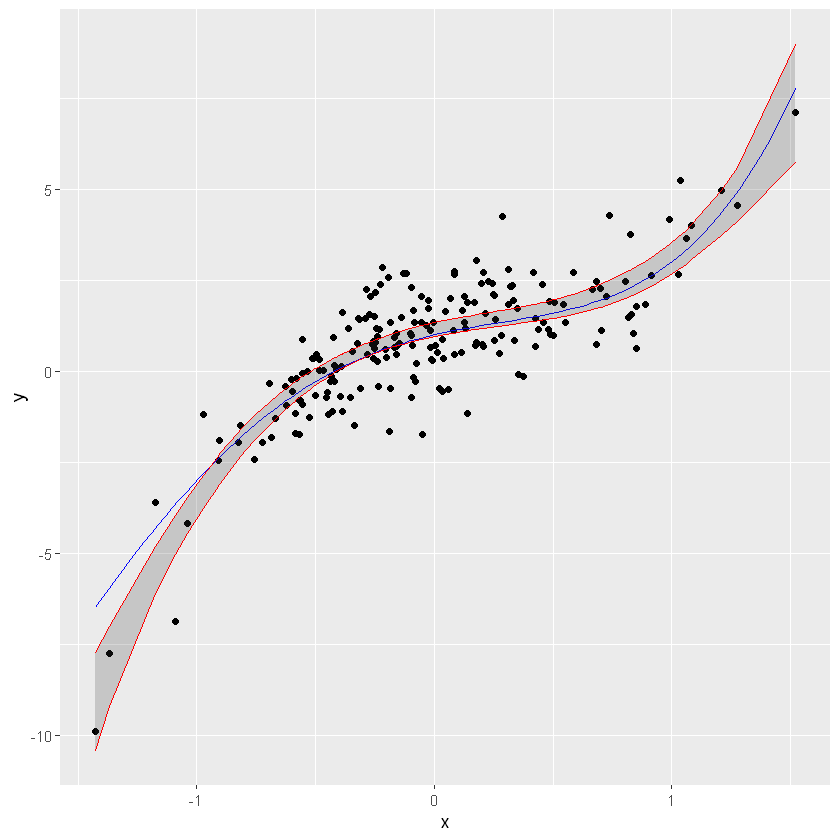

In [56]:
#Visualize analytic confidence intervals
low <- y_cons_hat - 2 * standard_errors
high <- y_cons_hat + 2 * standard_errors
df <- data.frame(X[,2], y, low, high)
ggp <- ggplot(df, aes(X[,2], y)) +    # ggplot2 plot without confidence band
  geom_point() +
  xlim(min(X[,2]), max(X[,2])) + 
  stat_function(fun = fun.true, col = "blue") + 
  geom_ribbon(aes(ymin = low, ymax = high), alpha = 0.2, col = "red") +
  labs(x = "x")
ggp

<br> b) Calculate the naive bootstrap confidence intervals (i.e. using the naive bootstrap quantiles) for *B* bootstrap draws from the original data, such that the nominal coverage for the two methods is the same.

In [26]:
B = 5000 #no. of bootstrap samples 
samples = samples.bs(B, data) #Generate B bootstrap samples
bs.estimates = fit.bs(samples, x_cons) #estimated values of f(x0)

#calculate bootstrap confidence intervals
# means = rowMeans(bs.estimates) #calculate the mean of the bootstrap estimations (for each point we considered)
q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles. First/second column stores lower/upper quantile
#calculate quantiles
for (i in 1:nrow(bs.estimates)){
    q[i,] = quantile(bs.estimates[i,], probs = c(0.025, 0.975))
}
ci_bs = cbind(2*y_cons_hat - q[,2], 2*y_cons_hat - q[,1]) #the confidence interval

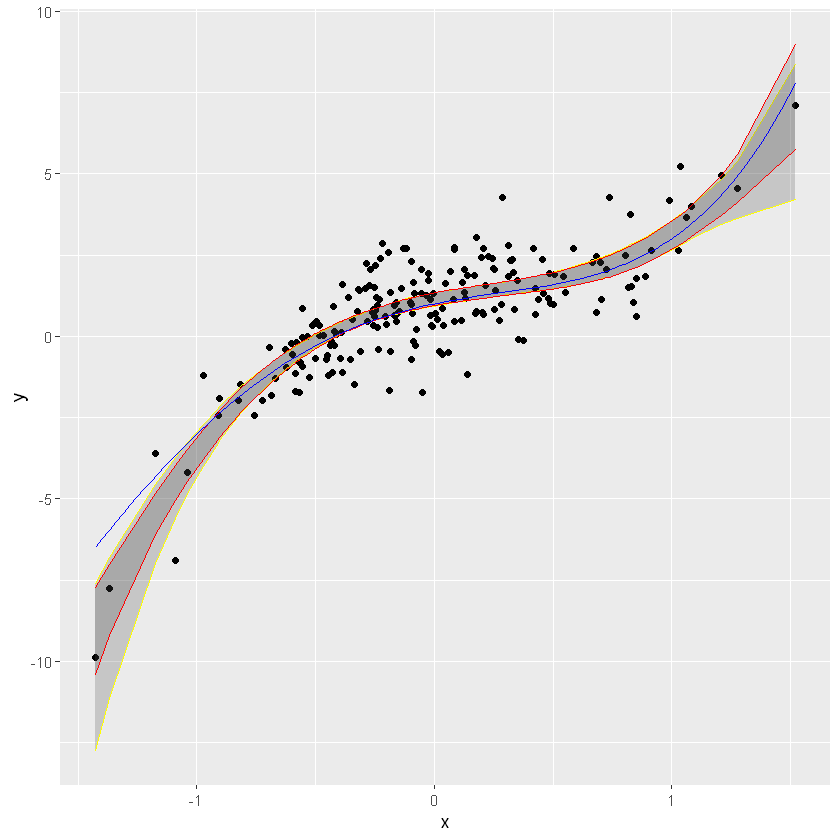

In [27]:
#Visualize bootstrap confidence intervals
low_bs <- ci_bs[,1]
high_bs <- ci_bs[,2]
df_bs <- data.frame(X[,2], y)
ggp_bs <- ggplot(df_bs, aes(X[,2], y)) +
  geom_point() +
  xlim(min(X[,2]), max(X[,2]))+ 
  geom_ribbon(aes(ymin = low_bs, ymax = high_bs), alpha = 0.2, col = "yellow") + 
  geom_ribbon(aes(ymin = low, ymax = high), alpha = 0.2, col = "red") +
  stat_function(fun = fun.true, col = "blue") +
  labs(x = "x")
ggp_bs

Warning message:
"Removed 12 rows containing missing values (geom_point)."

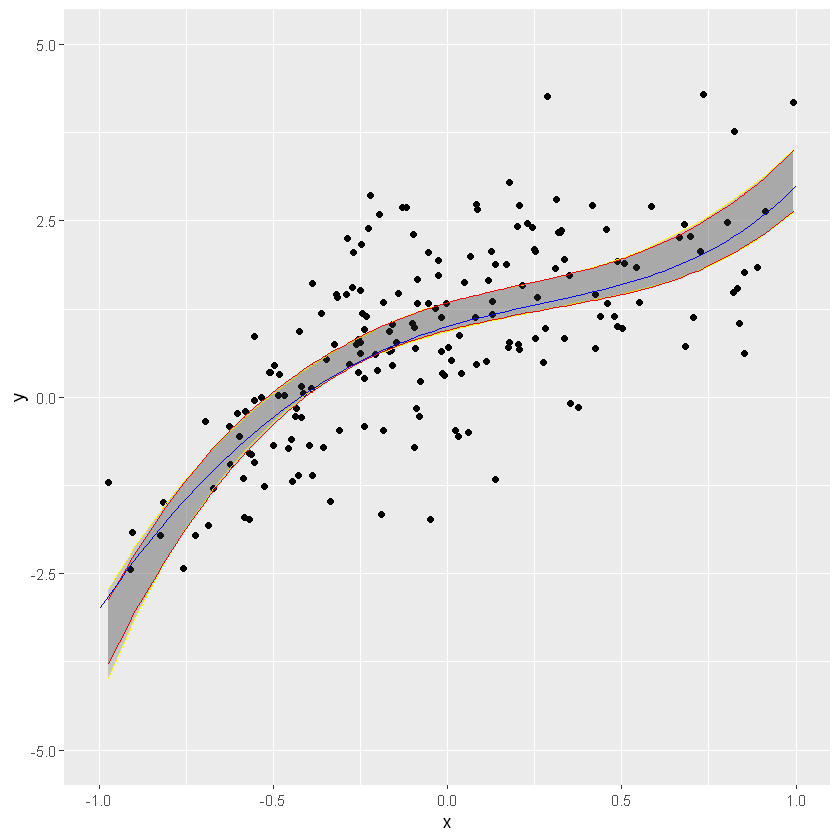

In [28]:
#Zooming in
ggp2 <- ggplot(df_bs, aes(X[,2], y)) + 
  geom_point() +
  xlim(min(-1), max(1)) +
  ylim(min(-5), max(5)) +
  geom_ribbon(aes(ymin = low_bs, ymax = high_bs), alpha = 0.2, col = "yellow") + 
  geom_ribbon(aes(ymin = low, ymax = high), alpha = 0.2, col = "red") +
  stat_function(fun = fun.true, col = "blue") +
  labs(x = "x")
ggp2

<br> c) Calculate the coverage probability at four different values of X, choosen by you.
<br> d) Calculate the interval length at four different values of X.

In [166]:
#Chose 4 values
x1 = -1
x2 = -0.1
x3 = 0.5
x4 = 1.2
x_c = c(x1, x2, x3, x4)

K = 5000 #no of iterations. More iterations means more accurate coverage probability
cprob_ana = c(0, 0, 0, 0) #vector that will contain the 4 coverage probabilities for the analytic method
ilength_ana = c(0, 0, 0, 0) #this will be the average interval length of the analytic confidence intervals

#####
#variables only needed to plot graphic later
y_hat4 = matrix(NA, nrow = 4, ncol = K) #fitted y values for the 4 chosen x values.
ci_analytic4_upper = matrix(NA, nrow = 4, ncol = K)
ci_analytic4_lower = matrix(NA, nrow = 4, ncol = K)
#####

for (i in 1:K){
  #Generate and fit data
  data = dgp(n, beta, mean.x, sd.x, mean.eps, sd.eps)
  y = data[,1]
  X = data[,2:6]
  linModel = lm(y~X+0)
  beta_hat = linModel$coefficients
  X_c = cbind(rep(1,4), x_c^1, x_c^2, x_c^3, x_c^4)
  y_c_hat = X_c %*% beta_hat #estimated value
  y_hat4[,i] = X_c %*% beta_hat
  y_c = X_c %*% beta #true value
  
  #calculate analytical standard errors and confidence intervals
  standard_errors = se.analytical_vector(x_c, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard errors for the 4 values
  ci_analytic = cbind(y_c_hat - 2 * standard_errors, y_c_hat + 2 * standard_errors) #calculate the 4 confidence intervals
  ci_analytic4_upper[,i] = y_c_hat + 2 * standard_errors
  ci_analytic4_lower[,i] = y_c_hat - 2 * standard_errors
  ilength_ana = ilength_ana + ci_analytic[,2]-ci_analytic[,1]
  
  #check if confidence intervals contain true value
  for(j in 1:4){
    if(y_c[j]>=ci_analytic[j,1] && y_c[j]<=ci_analytic[j,2]){
      cprob_ana[j] = cprob_ana[j] + 1 
    }
  }
}

cprob_ana = cprob_ana/K #coverage probabilities for the analytic method
ilength_ana = ilength_ana/K #average interval length of the analytic confidence intervals

[1] 0.9506

[1] 1.068744

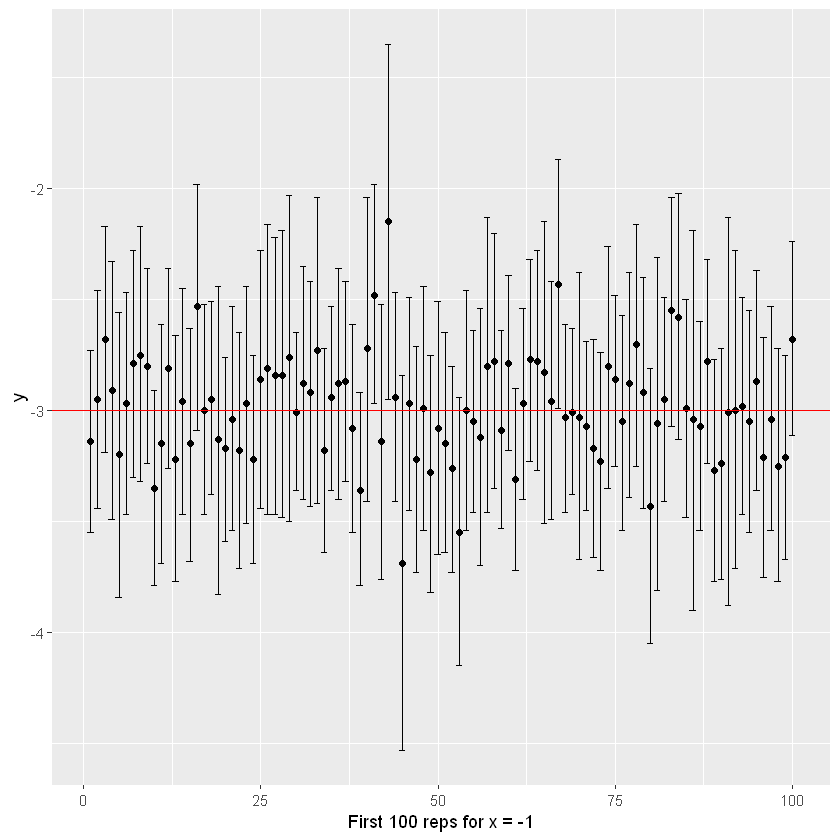

In [167]:
#Visualising analytical confidence intervals
#plot for x1=-1
X_c = cbind(rep(1,4), x_c^1, x_c^2, x_c^3, x_c^4)
plotdata1 <- round(data.frame(x = 1:100,
                              y = y_hat4[1,1:100],
                              lower = ci_analytic4_lower[1,1:100],
                              upper = ci_analytic4_upper[1,1:100]), 2)

ggplot(plotdata1, aes(x, y)) +
  geom_point() +
  geom_errorbar(aes(ymin = lower, ymax = upper)) +
  geom_hline(yintercept=X_c[1,]%*%beta, color = "red") +
  labs(x = "First 100 reps for x = -1")
cprob_ana[1]
ilength_ana[1]

[1] 0.9552

[1] 0.4057646

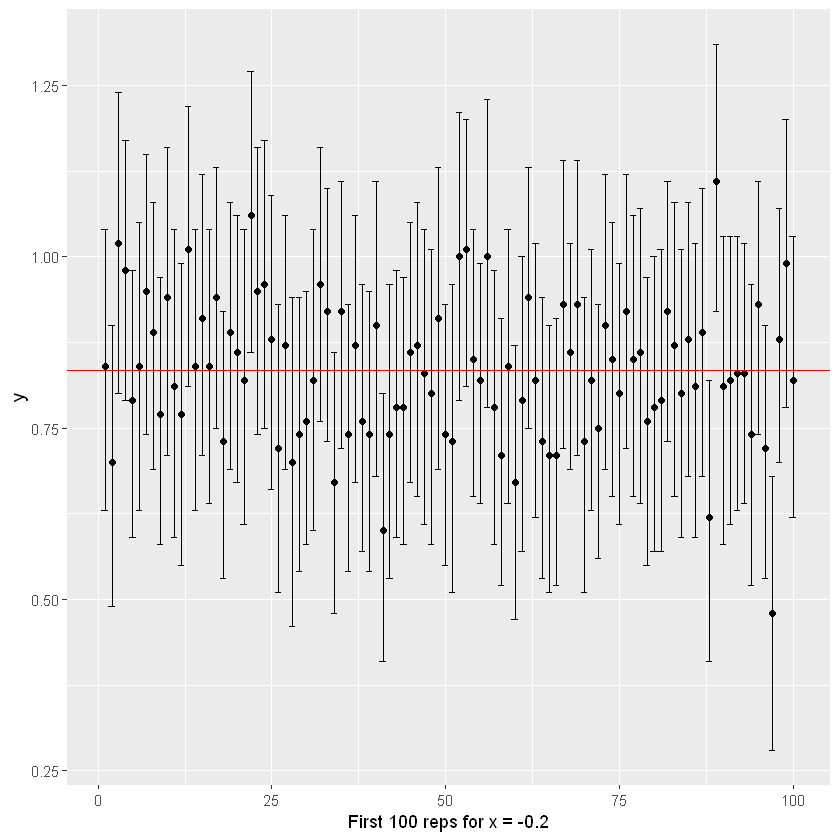

In [168]:
#plot for x2
plotdata2 <- round(data.frame(x = 1:100,
                              y = y_hat4[2,1:100],
                              lower = ci_analytic4_lower[2,1:100],
                              upper = ci_analytic4_upper[2,1:100]), 2)

ggplot(plotdata2, aes(x, y)) +
  geom_point() +
  geom_errorbar(aes(ymin = lower, ymax = upper)) +
  geom_hline(yintercept=X_c[2,]%*%beta, color = "red") +
  labs(x = "First 100 reps for x = -0.2")
cprob_ana[2]
ilength_ana[2]

[1] 0.9548

[1] 0.5100018

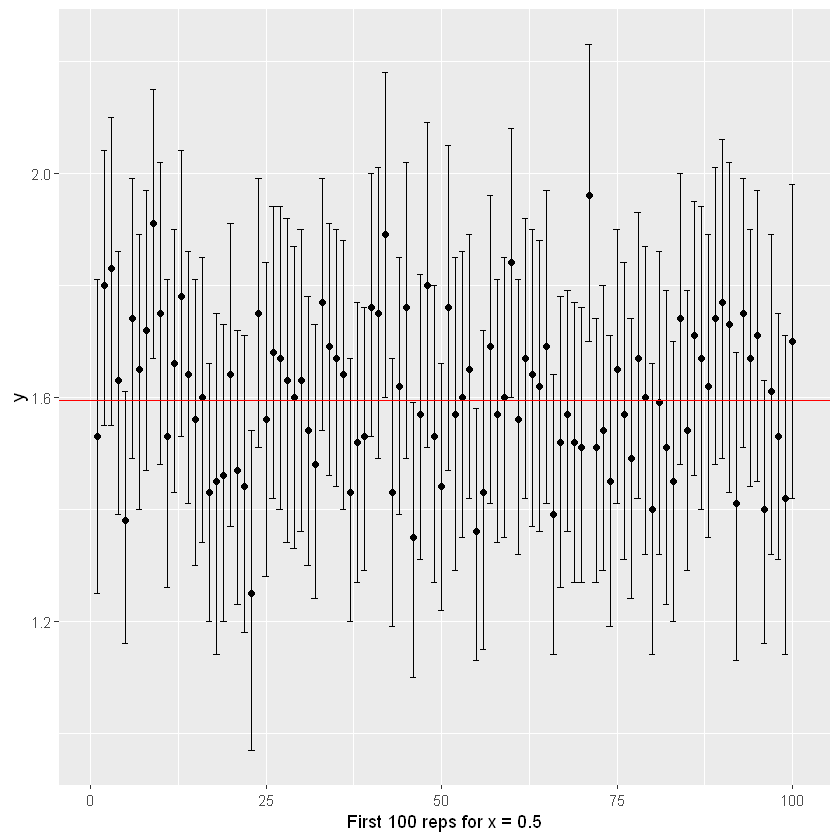

In [169]:
#plot for x3
plotdata3 <- round(data.frame(x = 1:100,
                              y = y_hat4[3,1:100],
                              lower = ci_analytic4_lower[3,1:100],
                              upper = ci_analytic4_upper[3,1:100]), 2)

ggplot(plotdata3, aes(x, y)) +
  geom_point() +
  geom_errorbar(aes(ymin = lower, ymax = upper)) +
  geom_hline(yintercept=X_c[3,]%*%beta, color = "red") +
  labs(x = "First 100 reps for x = 0.5")
cprob_ana[3]
ilength_ana[3]

[1] 0.9536

[1] 1.907891

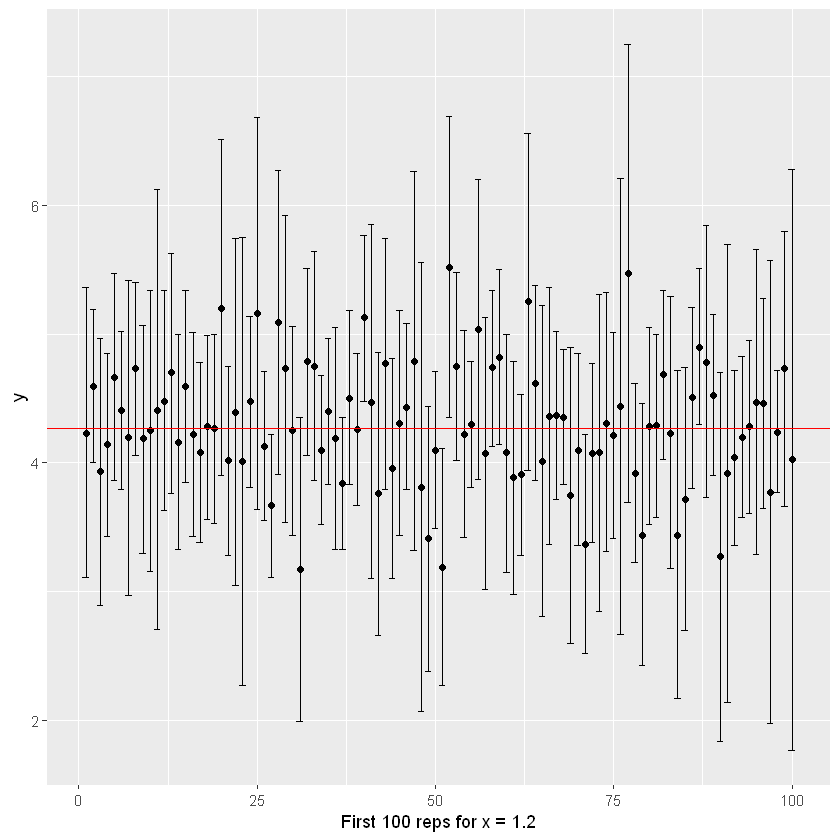

In [170]:
#plot for x4
plotdata4 <- round(data.frame(x = 1:100,
                              y = y_hat4[4,1:100],
                              lower = ci_analytic4_lower[4,1:100],
                              upper = ci_analytic4_upper[4,1:100]), 2)

ggplot(plotdata4, aes(x, y)) +
  geom_point() +
  geom_errorbar(aes(ymin = lower, ymax = upper)) +
  geom_hline(yintercept=X_c[4,]%*%beta, color = "red") +
  labs(x = "First 100 reps for x = 1.2")
cprob_ana[4]
ilength_ana[4]

## Exercise 2
<br> Evaluate the two types of confidence intervals above along two dimensions: *integral length* and *coverage probability*.
1. Calculate both for a small simulation study of 100 repetitions.
2. How could you change the data-generating process to give a competitive advantage to the bootstrap?
<br> Suggest two changes and check each in a simulation study.

In [146]:
reps = 100
N = 500 #no. of observations
B2 = 250
beta = rbind(1, 1.5, -1.5, 1.5, 0.5) #vector of true betas
mean.x = 0
sd.x = 0.5
mean.eps = 0 
sd.eps = sqrt(1)
x0 = 0.3 #value of interest

cprob_ana = 0 #this will be the coverage probability for the analytic method
cprob_bs = 0 #this will be the coverage probability for the bootstrap approach
int_ana = matrix(NA, nrow = reps, ncol = 2) #this will be the confidence intervals for the analytic method. In each row the left/right column contains the upper/lower bound of the conf. int.
int_bs = matrix(NA, nrow = reps, ncol = 2) #this will be the confidence intervals for the bootstrap

for (i in 1:reps){
  #Generate and fit data
  data = dgp(N, beta, mean.x, sd.x, mean.eps, sd.eps)
  y = data[,1]
  X = data[,2:6]
  linModel = lm(y~X+0)
  beta_hat = linModel$coefficients
  X0 = c(1, x0, x0^2, x0^3, x0^4)
  y0_hat = X0 %*% beta_hat #estimated value
  y0 = X0 %*% beta #true value
  
  #calculate analytical standard errors and confidence intervals
  standard_errors = se.analytical_vector(x0, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard error
  int_ana[i,] = cbind(y0_hat - 2 * standard_errors, y0_hat + 2 * standard_errors) #calculate confidence interval
  
  #calculate bootstrap confidence intervals
  samples = samples.bs(B2, data) #Generate B bootstrap samples
  bs.estimates = fit.bs(samples, x0) #estimated values of f(x0)

  q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles
  #calculate quantiles
  for (j in 1:nrow(bs.estimates)){
    q[j,] = quantile(bs.estimates[j,], probs = c(0.025, 0.975))
  }
    int_bs[i,] = cbind(2*y0_hat - q[,2], 2*y0_hat - q[,1]) #the naive bootstrap confidence interval
  
  #check if confidence intervals contain true value
  if(y0>=int_ana[i,1] && y0<=int_ana[i,2]){
    cprob_ana = cprob_ana + 1 
  }
  if(y0>=int_bs[i,1] && y0<=int_bs[i,2]){
    cprob_bs = cprob_bs + 1 
  }
}
cprob_ana = cprob_ana/reps #coverage probabilities for the analytic method
cprob_bs = cprob_bs/reps #coverage probabilities for the bootstrap approach
length_ana = int_ana[,2] - int_ana[,1]
length_bs = int_bs[,2] - int_bs[,1]


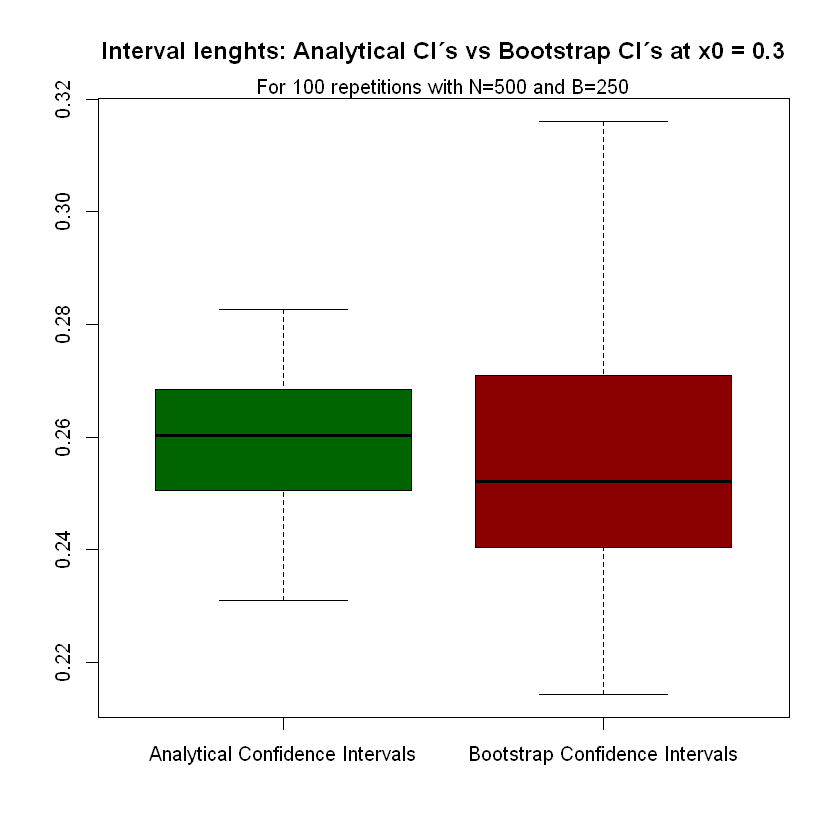

In [147]:
interval.length1<-data.frame(length_ana,length_bs)
names(interval.length1)[1] <- "ci.l.an"
names(interval.length1)[2] <- "ci.l.bs"
boxplot(interval.length1$ci.l.an,interval.length1$ci.l.bs,
       main = "Interval lenghts: Analytical CI´s vs Bootstrap CI´s at x0 = 0.3",
       names = c("Analytical Confidence Intervals","Bootstrap Confidence Intervals"),
       col = c("darkgreen","darkred"))
mtext("For 100 repetitions with N=500 and B=250",side=3)

In [148]:
#Computationally intensive code to calculate coverage probability (including bootstrap)
repititions = 100
M = 100
B3 = 250
no_of_obs = 500 #number of observations
beta = rbind(1, 1.5, -1.5, 1.5, 0.5) #vector of true betas
mean.x = 0
sd.x = 0.5
mean.eps = 0 
sd.eps = sqrt(1)
x0 = 0.3 #value of interest
cov_ana = rep(0, repititions)
cov_bs = rep(0, repititions)


for (k in 1:repititions){
  int_ana = matrix(0, nrow = M, ncol = 2)
  int_bs = matrix(0, nrow = M, ncol = 2)
  for(i in 1:M){
    #Generate and fit data
    data = dgp(no_of_obs, beta, mean.x, sd.x, mean.eps, sd.eps)
    y = data[,1]
    X = data[,2:6]
    linModel = lm(y~X+0)
    beta_hat = linModel$coefficients
    X0 = c(1, x0, x0^2, x0^3, x0^4)
    y0_hat = X0 %*% beta_hat #estimated value
    y0 = X0 %*% beta #true value
    
    #calculate analytical standard errors and confidence intervals
    standard_errors = se.analytical_vector(x0, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard error
    int_ana[i,] = cbind(y0_hat - 2 * standard_errors, y0_hat + 2 * standard_errors) #calculate confidence interval
    
    #calculate bootstrap confidence intervals
    samples = samples.bs(B3, data) #Generate B bootstrap samples
    bs.estimates = fit.bs(samples, x0) #estimated values of f(x0)
#     means = rowMeans(bs.estimates)
    q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles
    #calculate quantiles
    for (j in 1:nrow(bs.estimates)){
      q[j,] = quantile(bs.estimates[j,], probs = c(0.025, 0.975))
    }
      int_bs[i,] = cbind(2*y0_hat - q[,2], 2*y0_hat - q[,1]) #the naive bootstrap confidence interval
    
    #check if confidence intervals contain true value
    if(y0>=int_ana[i,1] && y0<=int_ana[i,2]){
      cov_ana[k] = cov_ana[k] + 1 
    }
    if(y0>=int_bs[i,1] && y0<=int_bs[i,2]){
      cov_bs[k] = cov_bs[k] + 1 
    }
  }
}
cov_ana = cov_ana/M
cov_bs = cov_bs/M

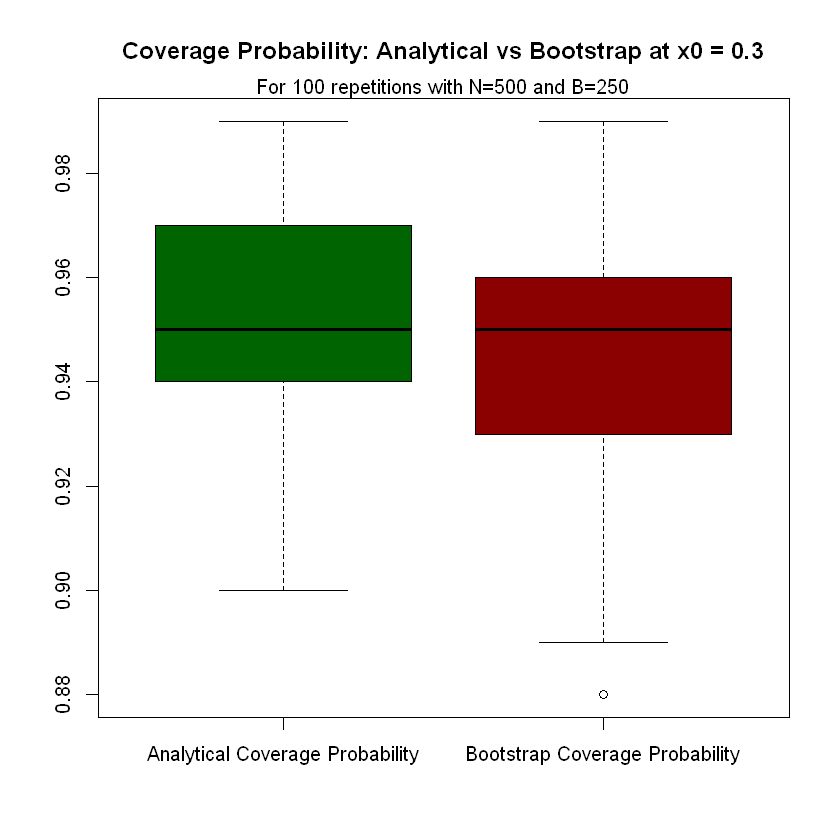

In [149]:
coverage.probability1<-data.frame(cov_ana,cov_bs)
names(coverage.probability1)[1] <- "cov.p.an"
names(coverage.probability1)[2] <- "cov.p.bs"
boxplot(coverage.probability1$cov.p.an,coverage.probability1$cov.p.bs,
       main = "Coverage Probability: Analytical vs Bootstrap at x0 = 0.3",
       names = c("Analytical Coverage Probability","Bootstrap Coverage Probability"),
       col = c("darkgreen","darkred"))
mtext("For 100 repetitions with N=500 and B=250",side=3)

In [150]:
# Relatively small sample size
reps = 100
N = 20 #no. of observations
B2 = 20
beta = rbind(1, 1.5, -1.5, 1.5, 0.5) #vector of true betas
mean.x = 0
sd.x = 0.5
mean.eps = 0 
sd.eps = sqrt(1)
x0 = 0.3 #value of interest

cprob_ana = 0 #this will be the coverage probability for the analytic method
cprob_bs = 0 #this will be the coverage probability for the bootstrap approach
int_ana = matrix(NA, nrow = reps, ncol = 2) #this will be the confidence intervals for the analytic method. In each row the left/right column contains the upper/lower bound of the conf. int.
int_bs = matrix(NA, nrow = reps, ncol = 2) #this will be the confidence intervals for the bootstrap

for (i in 1:reps){
  #Generate and fit data
  data = dgp(N, beta, mean.x, sd.x, mean.eps, sd.eps)
  y = data[,1]
  X = data[,2:6]
  linModel = lm(y~X+0)
  beta_hat = linModel$coefficients
  X0 = c(1, x0, x0^2, x0^3, x0^4)
  y0_hat = X0 %*% beta_hat #estimated value
  y0 = X0 %*% beta #true value
  
  #calculate analytical standard errors and confidence intervals
  standard_errors = se.analytical_vector(x0, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard error
  int_ana[i,] = cbind(y0_hat - 2 * standard_errors, y0_hat + 2 * standard_errors) #calculate confidence interval
  
  #calculate bootstrap confidence intervals
  samples = samples.bs(B2, data) #Generate B bootstrap samples
  bs.estimates = fit.bs(samples, x0) #estimated values of f(x0)
  q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles
  #calculate quantiles
  for (j in 1:nrow(bs.estimates)){
    q[j,] = quantile(bs.estimates[j,], probs = c(0.025, 0.975))
  }
    int_bs[i,] = cbind(2*y0_hat - q[,2], 2*y0_hat - q[,1]) #the naive bootstrap confidence interval
  
  #check if confidence intervals contain true value
  if(y0>=int_ana[i,1] && y0<=int_ana[i,2]){
    cprob_ana = cprob_ana + 1 
  }
  if(y0>=int_bs[i,1] && y0<=int_bs[i,2]){
    cprob_bs = cprob_bs + 1 
  }
}
cprob_ana = cprob_ana/reps #coverage probabilities for the analytic method
cprob_bs = cprob_bs/reps #coverage probabilities for the bootstrap approach
length_ana2 = int_ana[,2] - int_ana[,1]
length_bs2 = int_bs[,2] - int_bs[,1]

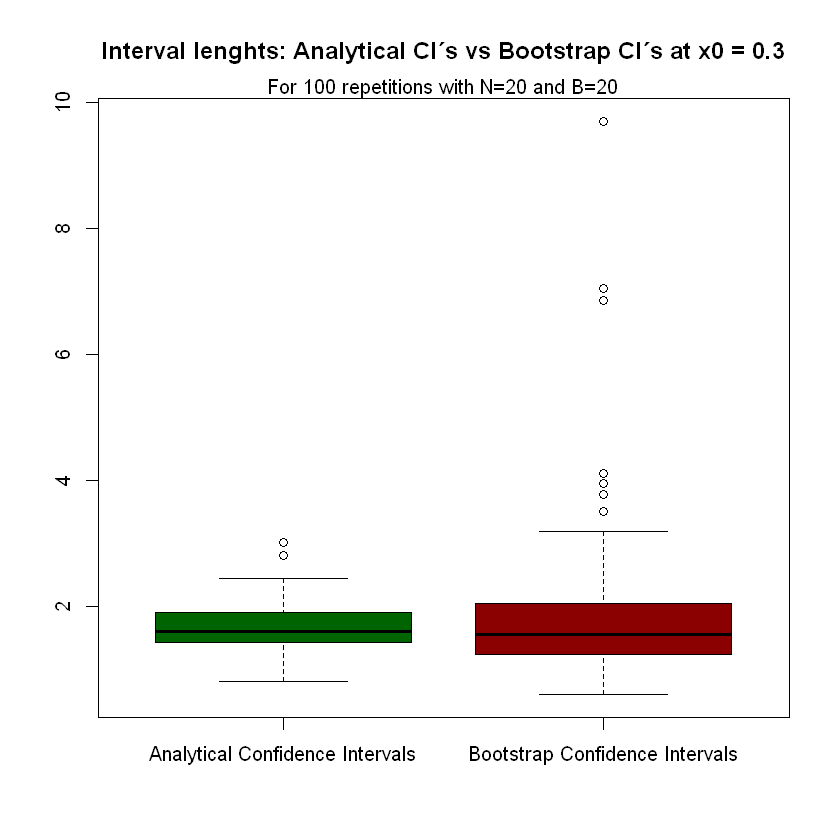

In [151]:
interval.length2<-data.frame(length_ana2,length_bs2)
names(interval.length2)[1] <- "ci.l.an"
names(interval.length2)[2] <- "ci.l.bs"
boxplot(interval.length2$ci.l.an,interval.length2$ci.l.bs,
       main = "Interval lenghts: Analytical CI´s vs Bootstrap CI´s at x0 = 0.3",
       names = c("Analytical Confidence Intervals","Bootstrap Confidence Intervals"),
       col = c("darkgreen","darkred"))
mtext("For 100 repetitions with N=20 and B=20",side=3)

In [152]:
# Relatively small sample size
#Computationally intensive code to calculate coverage probability (including bootstrap)
repititions = 100
M = 100
B3 = 20
no_of_obs = 20 #number of observations
beta = rbind(1, 1.5, -1.5, 1.5, 0.5) #vector of true betas
mean.x = 0
sd.x = 0.5
mean.eps = 0 
sd.eps = sqrt(1)
x0 = 0.3 #value of interest
cov_ana = rep(0, M)
cov_bs = rep(0, M)


for (k in 1:repititions){
  int_ana = matrix(0, nrow = M, ncol = 2)
  int_bs = matrix(0, nrow = M, ncol = 2)
  for(i in 1:M){
    #Generate and fit data
    data = dgp(no_of_obs, beta, mean.x, sd.x, mean.eps, sd.eps)
    y = data[,1]
    X = data[,2:6]
    linModel = lm(y~X+0)
    beta_hat = linModel$coefficients
    X0 = c(1, x0, x0^2, x0^3, x0^4)
    y0_hat = X0 %*% beta_hat #estimated value
    y0 = X0 %*% beta #true value
    
    #calculate analytical standard errors and confidence intervals
    standard_errors = se.analytical_vector(x0, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard error
    int_ana[i,] = cbind(y0_hat - 2 * standard_errors, y0_hat + 2 * standard_errors) #calculate confidence interval
    
    #calculate bootstrap confidence intervals
    samples = samples.bs(B3, data) #Generate B bootstrap samples
    bs.estimates = fit.bs(samples, x0) #estimated values of f(x0)

    q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles
    #calculate quantiles
    for (j in 1:nrow(bs.estimates)){
      q[j,] = quantile(bs.estimates[j,], probs = c(0.025, 0.975))
    }
      int_bs[i,] = cbind(2*y0_hat - q[,2], 2*y0_hat - q[,1]) #the naive bootstrap confidence interval
    
    #check if confidence intervals contain true value
    if(y0>=int_ana[i,1] && y0<=int_ana[i,2]){
      cov_ana[k] = cov_ana[k] + 1 
    }
    if(y0>=int_bs[i,1] && y0<=int_bs[i,2]){
      cov_bs[k] = cov_bs[k] + 1 
    }
  }
}
cov_ana2 = cov_ana/M
cov_bs2 = cov_bs/M

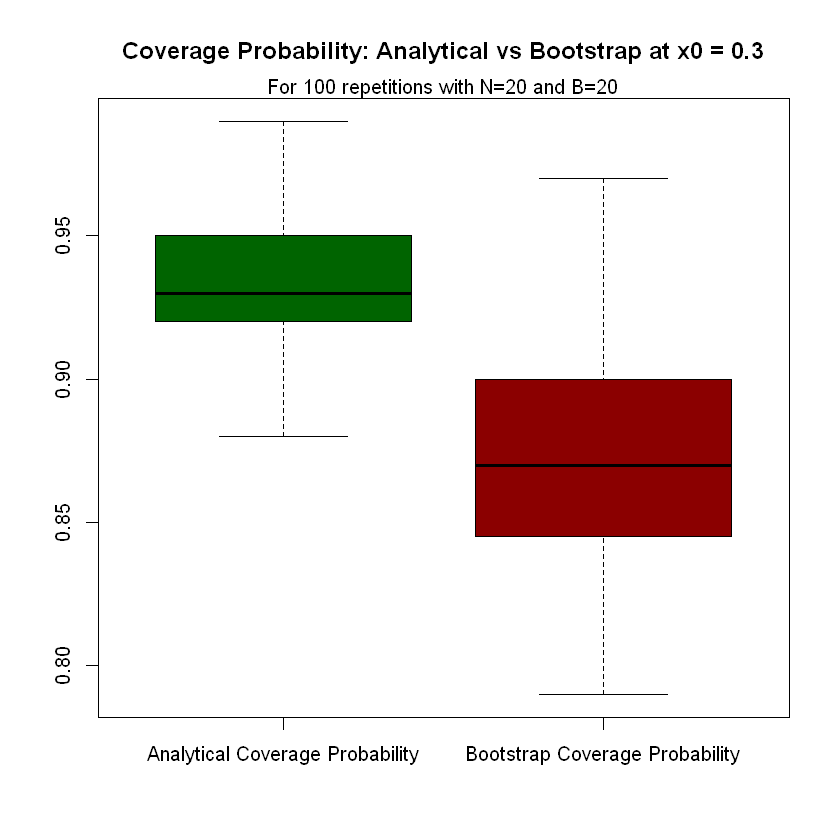

In [153]:
coverage.probability2<-data.frame(cov_ana2,cov_bs2)
names(coverage.probability2)[1] <- "cov.p.an"
names(coverage.probability2)[2] <- "cov.p.bs"
boxplot(coverage.probability2$cov.p.an,coverage.probability2$cov.p.bs,
       main = "Coverage Probability: Analytical vs Bootstrap at x0 = 0.3",
       names = c("Analytical Coverage Probability","Bootstrap Coverage Probability"),
       col = c("darkgreen","darkred"))
mtext("For 100 repetitions with N=20 and B=20",side=3)

In [15]:
#Non Normal Distributed Error Term
dgp.nn = function(n, beta, mean.x, sd.x, eps.mu, eps.sig,lambda){
  x <- rnorm(n, mean.x, sd.x)
  X <- cbind(rep(1,n), x^1, x^2, x^3, x^4)
  error <- remg(n,eps.mu,eps.sig,lambda)
  y <- X %*% beta + error
  return(cbind(y,X))
}

In [17]:
reps = 100
N = 500 #no. of observations
B2 = 250
beta = rbind(1, 1.5, -1.5, 1.5, 0.5) #vector of true betas
mean.x = 0
sd.x = 0.5
eps.mu = -3
eps.sig = 1
lambda = 1/3
x0 = 0.3 #value of interest

cprob_ana = 0 #this will be the coverage probability for the analytic method
cprob_bs = 0 #this will be the coverage probability for the bootstrap approach
int_ana = matrix(NA, nrow = reps, ncol = 2) #this will be the confidence intervals for the analytic method. In each row the left/right column contains the upper/lower bound of the conf. int.
int_bs = matrix(NA, nrow = reps, ncol = 2) #this will be the confidence intervals for the bootstrap

for (i in 1:reps){
  #Generate and fit data
  data = dgp.nn(N, beta, mean.x, sd.x, eps.mu, eps.sig,lambda)
  y = data[,1]
  X = data[,2:6]
  linModel = lm(y~X+0)
  beta_hat = linModel$coefficients
  X0 = c(1, x0, x0^2, x0^3, x0^4)
  y0_hat = X0 %*% beta_hat #estimated value
  y0 = X0 %*% beta #true value
  
  #calculate analytical standard errors and confidence intervals
  standard_errors = se.analytical_vector(x0, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard error
  int_ana[i,] = cbind(y0_hat - 2 * standard_errors, y0_hat + 2 * standard_errors) #calculate confidence interval
  
  #calculate bootstrap confidence intervals
  samples = samples.bs(B2, data) #Generate B bootstrap samples
  bs.estimates = fit.bs(samples, x0) #estimated values of f(x0)

  q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles
  #calculate quantiles
  for (j in 1:nrow(bs.estimates)){
    q[j,] = quantile(bs.estimates[j,], probs = c(0.025, 0.975))
  }
    int_bs[i,] = cbind(2*y0_hat - q[,2], 2*y0_hat - q[,1]) #the naive bootstrap confidence interval
  
  #check if confidence intervals contain true value
  if(y0>=int_ana[i,1] && y0<=int_ana[i,2]){
    cprob_ana = cprob_ana + 1 
  }
  if(y0>=int_bs[i,1] && y0<=int_bs[i,2]){
    cprob_bs = cprob_bs + 1 
  }
}
cprob_ana = cprob_ana/reps #coverage probabilities for the analytic method
cprob_bs = cprob_bs/reps #coverage probabilities for the bootstrap approach
length_ana3 = int_ana[,2] - int_ana[,1]
length_bs3 = int_bs[,2] - int_bs[,1]

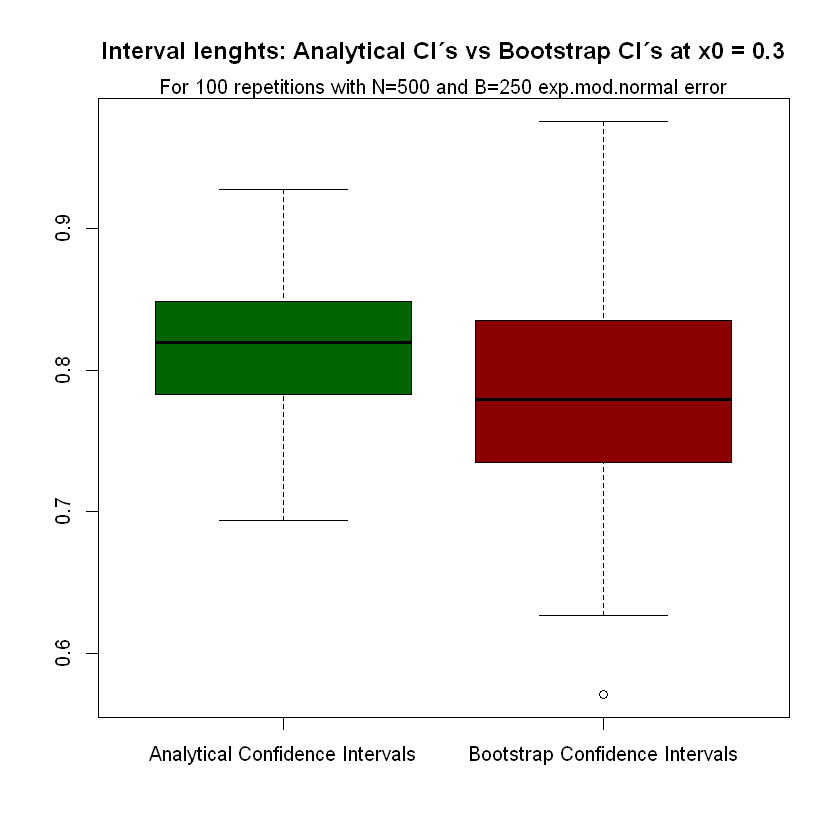

In [18]:
interval.length3<-data.frame(length_ana3,length_bs3)
names(interval.length3)[1] <- "ci.l.an"
names(interval.length3)[2] <- "ci.l.bs"
boxplot(interval.length3$ci.l.an,interval.length3$ci.l.bs,
       main = "Interval lenghts: Analytical CI´s vs Bootstrap CI´s at x0 = 0.3",
       names = c("Analytical Confidence Intervals","Bootstrap Confidence Intervals"),
       col = c("darkgreen","darkred"))
mtext("For 100 repetitions with N=500 and B=250 exp.mod.normal error",side=3)

In [19]:
#Computationally intensive code to calculate coverage probability (including bootstrap)
repititions = 100
M = 100
B3 = 100
no_of_obs = 100 #number of observations
beta = rbind(1, 1.5, -1.5, 1.5, 0.5) #vector of true betas
mean.x = 0
sd.x = 0.5
eps.mu = -3
eps.sig = 1
lambda = 1/3
x <- rnorm(no_of_obs, mean = mean.x, sd = sd.x)
X <- cbind(rep(1,no_of_obs), x, x^2, x^3, x^4)
error <- remg(N,eps.mu,eps.sig,lambda)
y <- X %*% beta + error
x0 = 0.3 #value of interest
cov_ana = rep(0, repititions)
cov_bs = rep(0, repititions)


for (k in 1:repititions){
  int_ana = matrix(0, nrow = M, ncol = 2)
  int_bs = matrix(0, nrow = M, ncol = 2)
  for(i in 1:M){
    #Generate and fit data
    data = dgp.nn(no_of_obs, beta, mean.x, sd.x, eps.mu, eps.sig, lambda)
    y = data[,1]
    X = data[,2:6]
    linModel = lm(y~X+0)
    beta_hat = linModel$coefficients
    X0 = c(1, x0, x0^2, x0^3, x0^4)
    y0_hat = X0 %*% beta_hat #estimated value
    y0 = X0 %*% beta #true value
    
    #calculate analytical standard errors and confidence intervals
    standard_errors = se.analytical_vector(x0, y = data[,1], X = data[,2:6], linModel) #calculate the analytical standard error
    int_ana[i,] = cbind(y0_hat - 2 * standard_errors, y0_hat + 2 * standard_errors) #calculate confidence interval
    
    #calculate bootstrap confidence intervals
    samples = samples.bs(B3, data) #Generate B bootstrap samples
    bs.estimates = fit.bs(samples, x0) #estimated values of f(x0)
    q = matrix(0, nrow = nrow(bs.estimates), ncol = 2) #q is going to store the bootstrap quantiles
    #calculate quantiles
    for (j in 1:nrow(bs.estimates)){
      q[j,] = quantile(bs.estimates[j,], probs = c(0.025, 0.975))
    }
      int_bs[i,] = cbind(2*y0_hat - q[,2], 2*y0_hat - q[,1]) #the naive bootstrap confidence interval
    
    #check if confidence intervals contain true value
    if(y0>=int_ana[i,1] && y0<=int_ana[i,2]){
      cov_ana[k] = cov_ana[k] + 1 
    }
    if(y0>=int_bs[i,1] && y0<=int_bs[i,2]){
      cov_bs[k] = cov_bs[k] + 1 
    }
  }
}
cov_ana3 = cov_ana/M
cov_bs3 = cov_bs/M

ERROR: Error in eval(expr, envir, enclos): Dimensionen [Produkt 100] passen nicht zur Länge des Objektes [500]


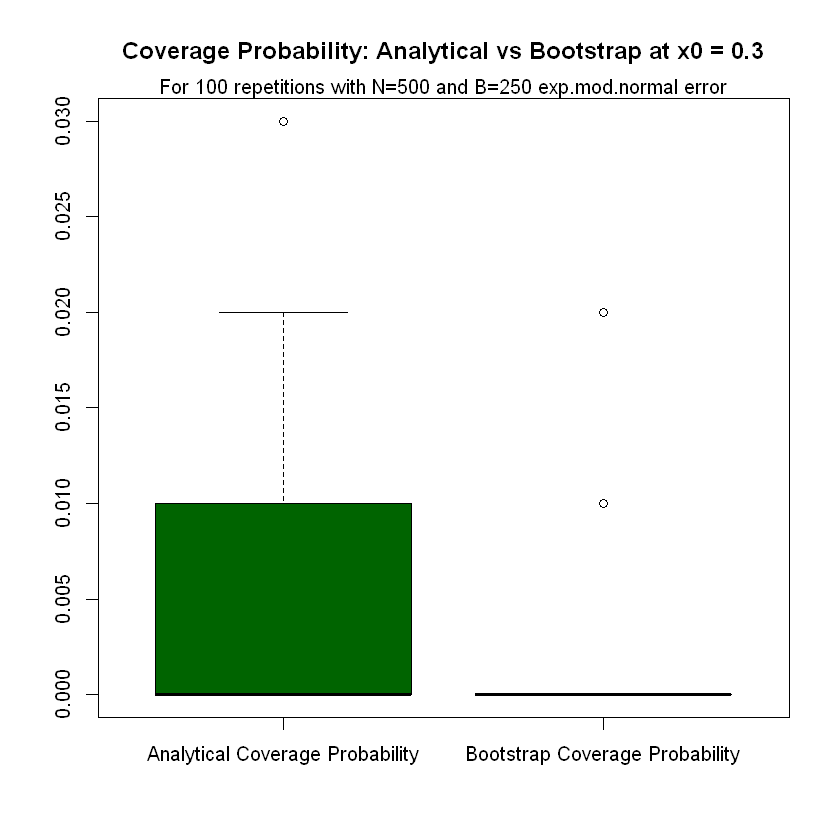

In [200]:
coverage.probability3<-data.frame(cov_ana3,cov_bs3)
names(coverage.probability3)[1] <- "cov.p.an"
names(coverage.probability3)[2] <- "cov.p.bs"
boxplot(coverage.probability3$cov.p.an,coverage.probability3$cov.p.bs,
       main = "Coverage Probability: Analytical vs Bootstrap at x0 = 0.3",
       names = c("Analytical Coverage Probability","Bootstrap Coverage Probability"),
       col = c("darkgreen","darkred"))
mtext("For 100 repetitions with N=500 and B=250 exp.mod.normal error",side=3)